<a href="https://colab.research.google.com/github/S1998raghu/S1998raghu2.github.io/blob/main/dataPreprocessingNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io



In [3]:
from google.colab import drive
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# # Step 2: Specify the path of the ZIP file and the target directory
# zip_file_path = '/content/drive/My Drive/Colab Notebooks/data.zip'
# target_dir = '/content/drive/My Drive/Colab Notebooks/data1'

# # Step 3: Create the target directory if it doesn't exist
# os.makedirs(target_dir, exist_ok=True)

# # Step 4: Unzip the file
# !unzip "{zip_file_path}" -d "{target_dir}"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16257_16556_8708_9007.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16556_16855_6914_7213.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16257_16556_6914_7213.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16556_16855_8708_9007.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_18948_19247_8110_8409.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_18350_18649_9605_9904.p

# New Section

In [4]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/My Drive/Colab Notebooks/data1/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

src_image_ids

['ESP_026602_1300',
 'ESP_072193_1845',
 'ESP_020415_1195',
 'ESP_067228_1820',
 'ESP_049512_1310',
 'ESP_070763_1790',
 'ESP_047596_1845',
 'ESP_019459_2185',
 'ESP_045865_1825',
 'ESP_026602_1300',
 'ESP_018828_2445',
 'ESP_070763_1790',
 'ESP_018828_2445',
 'ESP_011605_1170',
 'PSP_002904_1255',
 'ESP_066813_2360',
 'PSP_008120_2465',
 'ESP_020415_1195',
 'ESP_035667_2295',
 'ESP_040959_1355',
 'ESP_073664_1205',
 'ESP_072569_1320',
 'ESP_018002_1820',
 'ESP_019781_1300',
 'ESP_042279_1820',
 'ESP_026885_2295',
 'PSP_005315_1770',
 'ESP_040959_1355',
 'ESP_045865_1825',
 'PSP_006825_2465',
 'ESP_067228_1820',
 'ESP_068434_2450',
 'ESP_016518_2535',
 'ESP_048733_2075',
 'PSP_005315_1770',
 'ESP_072193_1845',
 'ESP_067228_1820',
 'ESP_039175_1200',
 'PSP_008120_2465',
 'ESP_053223_1770',
 'ESP_019781_1300',
 'ESP_038058_1205',
 'ESP_047596_1845',
 'ESP_055340_1185',
 'ESP_018828_2445',
 'ESP_072193_1845',
 'ESP_032207_1350',
 'PSP_002033_1325',
 'ESP_066813_2360',
 'ESP_018002_1820',


In [5]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/My Drive/Colab Notebooks/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/My Drive/Colab Notebooks/val_source_images.txt')
test_ids = load_text_ids('/content/drive/My Drive/Colab Notebooks/test_source_images.txt')

validate_ids
train_ids
test_ids



['ESP_016518_2535',
 'ESP_017506_2450',
 'ESP_017717_2450',
 'ESP_019207_2450',
 'ESP_026602_1300',
 'ESP_026885_2295',
 'ESP_028501_1295',
 'ESP_035667_2295',
 'ESP_047596_1845',
 'ESP_055340_1185',
 'ESP_066956_2450',
 'ESP_067022_2450',
 'ESP_067517_1430',
 'ESP_068038_2450',
 'ESP_068434_2450',
 'ESP_070763_1790',
 'ESP_072796_1295',
 'PSP_006825_2465']

In [6]:
# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)
subdir_splits

['test',
 'train',
 'train',
 'train',
 'validate',
 'test',
 'test',
 'train',
 'train',
 'test',
 'train',
 'test',
 'train',
 'validate',
 'train',
 'validate',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'test',
 'validate',
 'train',
 'train',
 'test',
 'train',
 'test',
 'test',
 'validate',
 'validate',
 'train',
 'train',
 'train',
 'train',
 'validate',
 'train',
 'train',
 'test',
 'test',
 'train',
 'train',
 'validate',
 'train',
 'validate',
 'train',
 'train',
 'validate',
 'train',
 'train',
 'train',
 'validate',
 'train',
 'train',
 'validate',
 'test',
 'train',
 'test',
 'train',
 'train',
 'train',
 'test',
 'train',
 'validate',
 'test',
 'train',
 'validate',
 'train',
 'validate',
 'test',
 'train',
 'test',
 'train',
 'test',
 'validate',
 'test',
 'validate',
 'train',
 'validate',
 'train',
 'validate',
 'validate',
 'train',
 'test',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'test',
 'train',
 'v

In [7]:
import random
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
def load_and_preprocess(img_loc, label):


  def _inner_function(img_loc, label):

    img_loc_str = img_loc.numpy().decode('utf-8')
# Load image using PIL and convert to RGB
    img = Image.open(img_loc_str).convert('RGB')

 # Convert PIL image to numpy array
    img = np.array(img)
    img = tf.image.resize(img, [299, 299])

 # Normalize the image to the [0, 1] range
    img = img / 255.0

# Convert label to integer (assuming binary classification)
    label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
    return img, label

# Wrap the Python function
  X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

 # Set the shape of the tensors
  X.set_shape([299, 299, 3])
  y.set_shape([]) # Scalar label

  return X, y




In [8]:
def load_and_preprocess_train(img_loc, label):
    # Load and decode the image
    img = tf.io.read_file(img_loc)
    img = tf.io.decode_png(img, channels=3)

    # Cropping
    img = tf.image.random_crop(img, size=[250, 250, 3])  # Adjust the size as needed

    # Random Zoom (resize back to original size after cropping)
    img = tf.image.resize(img, [299, 299])

    # Random Rotation
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random Flip (Horizontal)
    img = tf.image.random_flip_left_right(img)

    # Random Contrast Adjustment
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = img / 255.0
    # Random Translation
    img = tf.image.pad_to_bounding_box(img, offset_height=10, offset_width=10, target_height=310, target_width=310)
    img = tf.image.random_crop(img, size=[299, 299, 3])

    # Convert label to a tensor
    label = tf.where(tf.equal(label, 'frost'), 1, 0)

    return img, label


In [9]:


def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 16

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)


tf_dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:

for images, labels in tf_dataset_train.take(1):

    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print(len(tf_dataset_val))


Image batch shape: (16, 299, 299, 3)
Label batch shape: (16,)
494


Epoch 1/20
883/883 [==============================] - 393s 426ms/step - loss: 37.7000 - accuracy: 0.6554 - val_loss: 28.3279 - val_accuracy: 0.2520
Epoch 2/20
883/883 [==============================] - 356s 403ms/step - loss: 18.0219 - accuracy: 0.6486 - val_loss: 13.9182 - val_accuracy: 0.2311
Epoch 3/20
883/883 [==============================] - 355s 401ms/step - loss: 7.4251 - accuracy: 0.6736 - val_loss: 6.1744 - val_accuracy: 0.2310
Epoch 4/20
883/883 [==============================] - 373s 423ms/step - loss: 3.2639 - accuracy: 0.7038 - val_loss: 30.4133 - val_accuracy: 0.2310
Epoch 5/20
883/883 [==============================] - 354s 401ms/step - loss: 3.4630 - accuracy: 0.7139 - val_loss: 42.0776 - val_accuracy: 0.2310
Epoch 6/20
883/883 [==============================] - 122s 137ms/step - loss: 8.3395 - accuracy: 0.6455
Test Loss: 8.339499473571777
Test Accuracy: 0.645513117313385


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training history is now saved to: /content/drive/My Drive/Colab Notebooks/saved_model_history.json


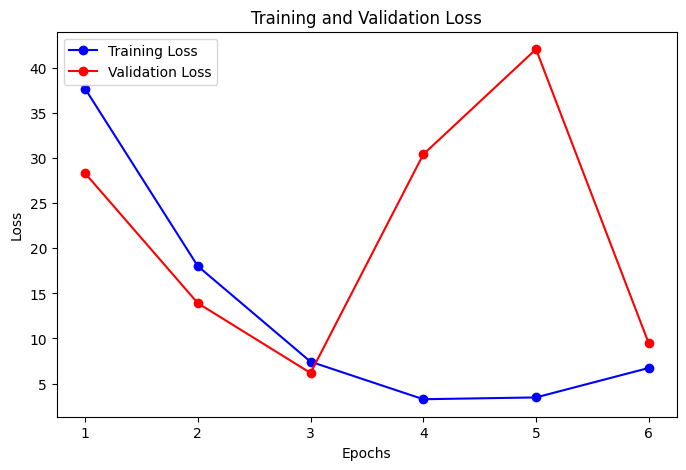

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import json

model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_path = '/content/drive/My Drive/Colab Notebooks/saved_model.h5'
model.save(model_path)
history_json = json.dumps(history.history)


history_path = model_path.replace('.h5', '_history.json')
with open(history_path, 'w') as f:
    f.write(history_json)
print("Training history is now saved to:", history_path)




train_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(train_loss) + 1)

    # Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def get():
    try:

        model_path = '/content/drive/My Drive/Colab Notebooks/saved_model.h5'
        model = tf.keras.models.load_model(model_path)
        print("saved model from:", model_path)
    except IOError:

        model = create_model()
        print("Model not found. Created new ")
    return model

model = get()

saved model from: /content/drive/My Drive/Colab Notebooks/saved_model.h5


In [13]:
import json
from tensorflow.keras.callbacks import EarlyStopping


train_model = False
if train_model:

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(
        tf_dataset_train,
        epochs=20,
        validation_data=tf_dataset_val,
        callbacks=[early_stopping]
    )

    model.save(model_path)
    print("Model is now saved to:", model_path)


    history_json = json.dumps(history.history)

    history_path = model_path.replace('.h5', '_history.json')
    with open(history_path, 'w') as f:
        f.write(history_json)
    print("Training history is now saved to:", history_path)

else:
    print("Using the loaded model")


Using the loaded model


In [14]:

true_labels = []
for _, label in tf_dataset_test:
    true_labels.extend(label.numpy())




In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

probabilities = model.predict(tf_dataset_test)

predictions = np.argmax(probabilities, axis=1)



precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


883/883 [==============================] - 145s 164ms/step
Precision: 0.6506350792065078
Recall: 0.9924893871775334
F1 Score: 0.7860006034222663


In [17]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False


16705208/16705208 [==============================] - 2s 0us/step


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)  # New FC layer
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)



model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
model_path = '/content/drive/My Drive/Colab Notebooks/saved_model_efficientnet.h5'
model.save(model_path)

history_json = json.dumps(history.history)


history_path = model_path.replace('.h5', '_history_efficientnet.json')
with open(history_path, 'w') as f:
    f.write(history_json)
print("Training history is now saved to:", history_path)


Epoch 1/20
883/883 [==============================] - 185s 198ms/step - loss: 0.8865 - accuracy: 0.6085 - val_loss: 0.7336 - val_accuracy: 0.2394
Epoch 2/20
883/883 [==============================] - 169s 192ms/step - loss: 0.6590 - accuracy: 0.6374 - val_loss: 0.6866 - val_accuracy: 0.5949
Epoch 3/20
883/883 [==============================] - 167s 189ms/step - loss: 0.6398 - accuracy: 0.6543 - val_loss: 0.6975 - val_accuracy: 0.3601
Epoch 4/20
883/883 [==============================] - 167s 189ms/step - loss: 0.6318 - accuracy: 0.6545 - val_loss: 0.7497 - val_accuracy: 0.2310
Epoch 5/20
883/883 [==============================] - 138s 156ms/step - loss: 0.6747 - accuracy: 0.6873
Test Loss: 0.6747193336486816
Test Accuracy: 0.6873008012771606


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training history is now saved to: /content/drive/My Drive/Colab Notebooks/saved_model_efficientnet_history_efficientnet.json


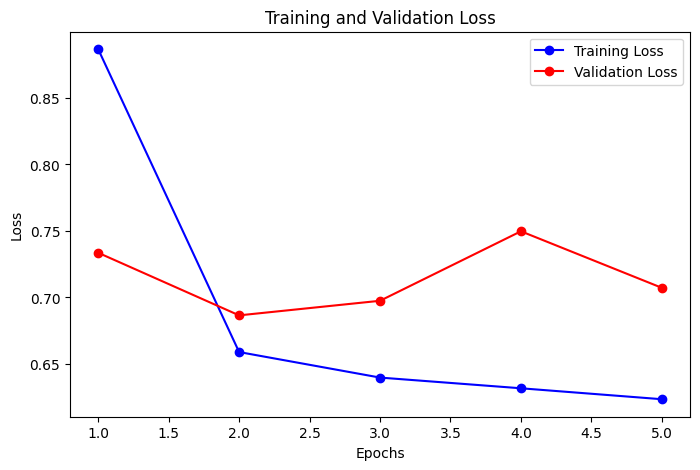

In [19]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

    # Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
true_labels = []
for _, label in tf_dataset_test:
    true_labels.extend(label.numpy())

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

probabilities = model.predict(tf_dataset_test)

predictions = np.argmax(probabilities, axis=1)

precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



883/883 [==============================] - 134s 149ms/step
Precision: 0.6506440171737913
Recall: 0.7587895939915097
F1 Score: 0.7005678106627807


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/20
883/883 [==============================] - 195s 215ms/step - loss: 0.3908 - accuracy: 0.8466 - val_loss: 1.3309 - val_accuracy: 0.5352
Epoch 2/20
883/883 [==============================] - 186s 210ms/step - loss: 0.2985 - accuracy: 0.8780 - val_loss: 1.9294 - val_accuracy: 0.4354
Epoch 3/20
883/883 [==============================] - 240s 271ms/step - loss: 0.2789 - accuracy: 0.8898 - val_loss: 2.5797 - val_accuracy: 0.4412
Epoch 4/20
883/883 [==============================] - 177s 199ms/step - loss: 0.6859 - accuracy: 0.8054
Test Loss: 0.685865581035614
Test Accuracy: 0.8054394721984863


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training history is now saved to: /content/drive/My Drive/Colab Notebooks/saved_model_resnet50_history_resnet50.json


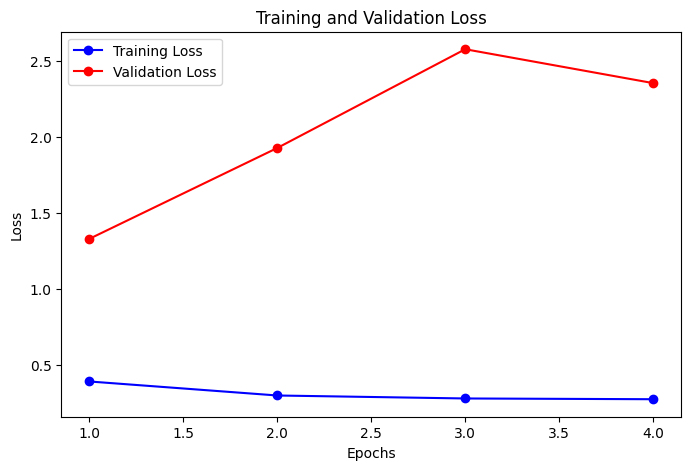

883/883 [==============================] - 160s 180ms/step
Precision: 0.6486830926083262
Recall: 0.8310656362251007
F1 Score: 0.7286348236865964


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import json

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_path = '/content/drive/My Drive/Colab Notebooks/saved_model_resnet50.h5'
model.save(model_path)

history_json = json.dumps(history.history)
history_path = model_path.replace('.h5', '_history_resnet50.json')
with open(history_path, 'w') as f:
    f.write(history_json)
print("Training history is now saved to:", history_path)

train_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(train_loss) + 1)

    # Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
true_labels = []
for _, label in tf_dataset_test:
    true_labels.extend(label.numpy())

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

probabilities = model.predict(tf_dataset_test)

predictions = np.argmax(probabilities, axis=1)

precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/20
883/883 [==============================] - 267s 297ms/step - loss: 0.1586 - accuracy: 0.9404 - val_loss: 2.5560 - val_accuracy: 0.5390
Epoch 2/20
883/883 [==============================] - 223s 252ms/step - loss: 0.1097 - accuracy: 0.9594 - val_loss: 3.3779 - val_accuracy: 0.4878
Epoch 3/20
883/883 [==============================] - 260s 294ms/step - loss: 0.0921 - accuracy: 0.9649 - val_loss: 1.8655 - val_accuracy: 0.6558
Epoch 4/20
883/883 [==============================] - 228s 257ms/step - loss: 0.0857 - accuracy: 0.9692 - val_loss: 2.8443 - val_accuracy: 0.6169
Epoch 5/20
883/883 [==============================] - 261s 296ms/step - loss: 0.0860 - accuracy: 0.9689 - val_loss: 3.1153 - val_accuracy: 0.5496
Epoch 6/20
883/883 [==============================] - 257s 291ms/step - loss: 0.0780 - accuracy: 0.9709 - val_loss: 1.6827 - val_accuracy: 0.7086
Epoch 7/20
883/883 [==============================] - 221s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training history is now saved to: /content/drive/My Drive/Colab Notebooks/saved_model_vgg16_history_vgg16.json


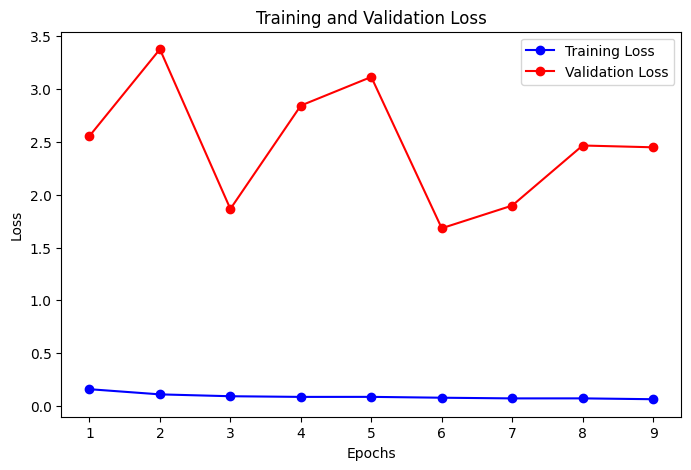

883/883 [==============================] - 187s 211ms/step
Precision: 0.6561804893549412
Recall: 0.6743224121040601
F1 Score: 0.6651277646553575


In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)


test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_path = '/content/drive/My Drive/Colab Notebooks/saved_model_vgg16.h5'
model.save(model_path)

history_json = json.dumps(history.history)
history_path = model_path.replace('.h5', '_history_vgg16.json')
with open(history_path, 'w') as f:
    f.write(history_json)
print("Training history is now saved to:", history_path)


train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


true_labels = []
for _, label in tf_dataset_test:
    true_labels.extend(label.numpy())


probabilities = model.predict(tf_dataset_test)

predictions = np.argmax(probabilities, axis=1)


precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


### on comparing CNN+MLP with the 3 transfer learning models:-
###  CNN+MLP - Test Accuracy: 0.64551311731338
###  Efficient net - Test Accuracy : 0.6873008012771606
###  ResNet - Test Accuracy - 0.8054394721984863
### Vgg16 - Test Accuracy - 0.9813017845153809
** We find Vgg16 to have the highest test accuracy**

the superior performance of VGG16 in tests could be due to its depth and the effectiveness of its architecture in capturing the features of my dataset.VGG16 is known for its deep architecture with 16 layers. This is much better than our 3 layer CNN custom model .Despite being simple in its design (primarily using 3x3 convolutions), Vgg's very effective at feature extraction. This depth allows it to learn complex patterns in data.
Though resnet and efficient net are also equally exomplex, in this case vgg is the most relevant to our dataset.

CNN+ MLP :-

Precision: 0.6506350792065078
Recall: 0.9924893871775334
F1 Score: 0.7860006034222663

Efficient Net :-

Precision: 0.6506440171737913
Recall: 0.7587895939915097
F1 Score: 0.7005678106627807

ResNet:

Precision: 0.6486830926083262
Recall: 0.8310656362251007
F1 Score: 0.7286348236865964

Vgg16:

Precision: 0.6561804893549412
Recall: 0.6743224121040601
F1 Score: 0.6651277646553575